# Body Fat Analysis

Since the body fat is technically hard to measure, our target is to estimate the males' body fat by using certain body measurements as the predictors. 

The data set has 252 observations and 16 variables. The variables including 14 readily available clinical body measurements. And the other two variables are the underwater body density and body fat. The body fat variable is deduced by the underwater body density variable, and the underwater body density is technically hard to measure under common condition.

Since our target is to estimate the body fat, and the body fat variable, and the underwater density variable have fixed relationship using the formula created by Siri (1956), we decide to directly use the body fat variable as the outcome variable and ignore the underwater denstiy variable.

Obviously, the original predictors are the other variables of the data set. We Initially have 14 predictors, which are shown below.

In [2]:
dat <- read.csv('BodyFat.csv')
predictor <- dat[,4:17]
print(colnames(predictor))

 [1] "AGE"       "WEIGHT"    "HEIGHT"    "ADIPOSITY" "NECK"      "CHEST"    
 [7] "ABDOMEN"   "HIP"       "THIGH"     "KNEE"      "ANKLE"     "BICEPS"   
[13] "FOREARM"   "WRIST"    


## 1.

## 2. Data Visualizing and Cleaning

In [3]:
library(tidyverse)
library(knitr)
library(kableExtra)
library(reshape)
library(corrplot)
library(dplyr)
library(ggplot2)
library(car)
dat <- read.csv('BodyFat.csv') %>%
  .[,-1]

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape’

The following object is masked from ‘package:dplyr’:

    rename

The following objects are masked from ‘package:tidyr’:

    expand, smiths

corrplot 0.84 loaded
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some



Using  as id variables


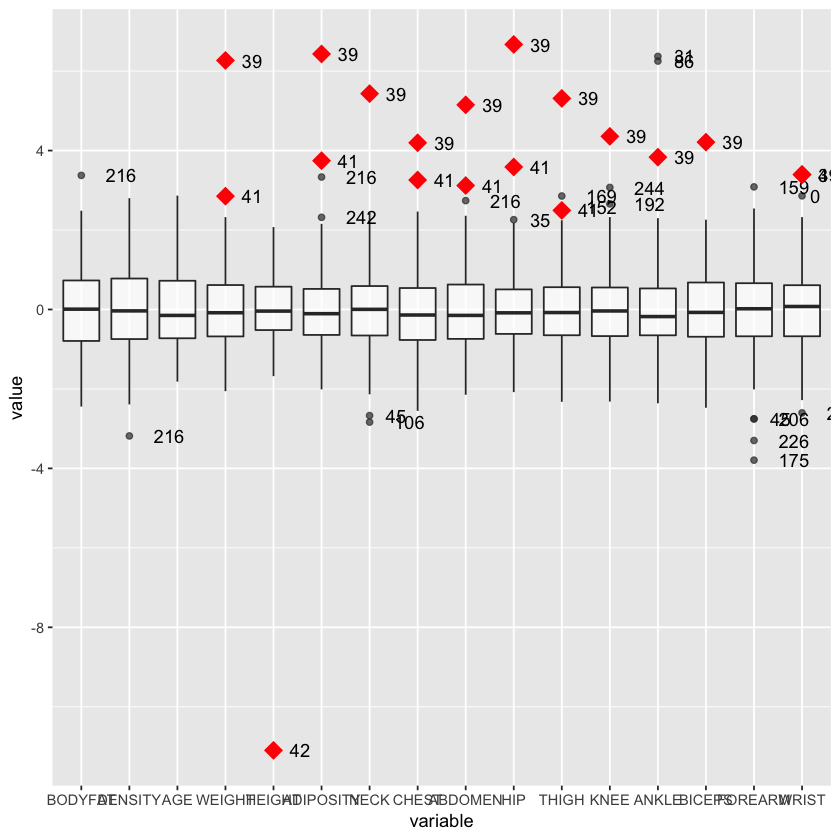

In [4]:
is_outlier <- function(x) {#Function to detect outlier
  return(x < quantile(x, 0.25) - 1.5 * IQR(x) | x > quantile(x, 0.75) + 1.5 * IQR(x))
}

clean_and_plot <- function(dt){
  k = nrow(dt)
  dat_tmp = dt %>%
    scale(.) %>%
    as.data.frame(.) %>%
    melt(.) %>%
    group_by(variable) %>%
    mutate(outlier = ifelse(is_outlier(value), value, as.numeric(NA)))
  
  for(i in 1:nrow(dat_tmp)){ #Change the outlier value to their index
    if(!is.na(dat_tmp$outlier[i])) 
      dat_tmp$outlier[i] = i %% nrow(dt)
  }
  
  p1 = ggplot(data = dat_tmp,aes(x = variable, y = value))+ #Boxplot with outlier indexed
    geom_boxplot(alpha = 0.7)+
    geom_text(aes(label = outlier), na.rm = TRUE, hjust = -0.8)
  return(list(p1, dat_tmp, k)) #Return Original Boxplot, transformed data matrix and number of rows.
}

tidyup <- function(dt,s){ # Try to put red color on the user-defined observations
  dat_tmp = dt[[2]]
  dat_tmp$idx = rep(1:dt[[3]],16)
  idx_save = c()
  for(i in 1: nrow(dat_tmp)){
    if(!is.na(dat_tmp$outlier[i]) & dat_tmp$outlier[i] %in% s){
      idx_save = c(idx_save ,i)
    }
  }
  p1 = dt[[1]] + geom_point(data = dat_tmp[idx_save,], color = 'red', shape = 18, size = 5)
  return(p1)
}
tidyup(clean_and_plot(dat), c(39,41,42))

According to the plot, we delete 39 and 41, because they are over-weighted and can be seen as outlier in many variables. And we delete 42, because this man is only 70cm tall.

Using  as id variables


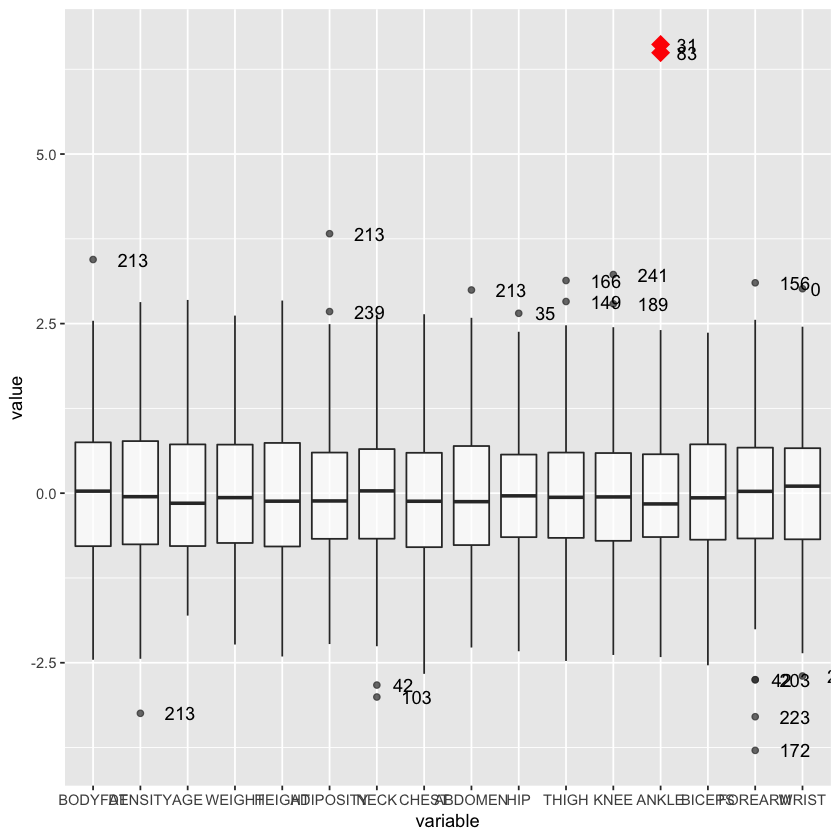

In [5]:
dat <- dat[-c(39, 41, 42),]
tidyup(clean_and_plot(dat), c(31, 83))

After we delete the observations 39, 41 and 42, we draw the box plot again, and find that the observations 31 and 83 have uncommon ankle circumference, so we decide to delete 31 and 83. 

Using  as id variables


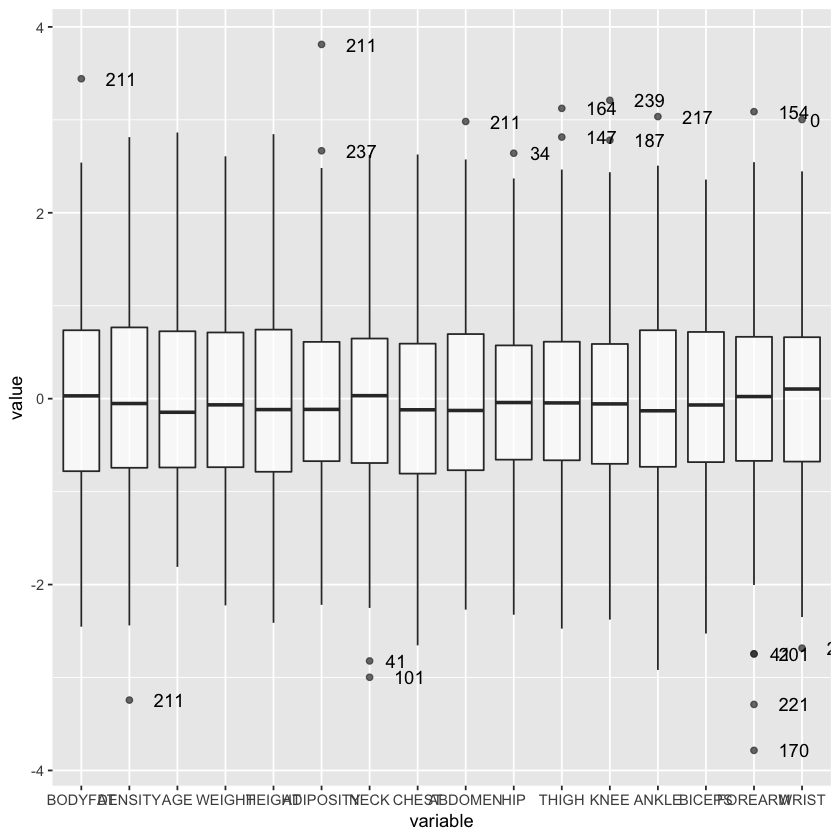

In [6]:
dat <- dat[-c(31, 83),]
tidyup(clean_and_plot(dat), c())

Now, from the box plot we cannot find any unusual observations.

However, we find that there exist Inconsistent between the real BODYFAT data and the calculated BODYFAT data. We consider the BODYFAT variable as the real data, and use the formula to calculate the BODYFAT using the DENSITY variable. Then we compare this two BODYFAT data, and we find there are four points which are strange.

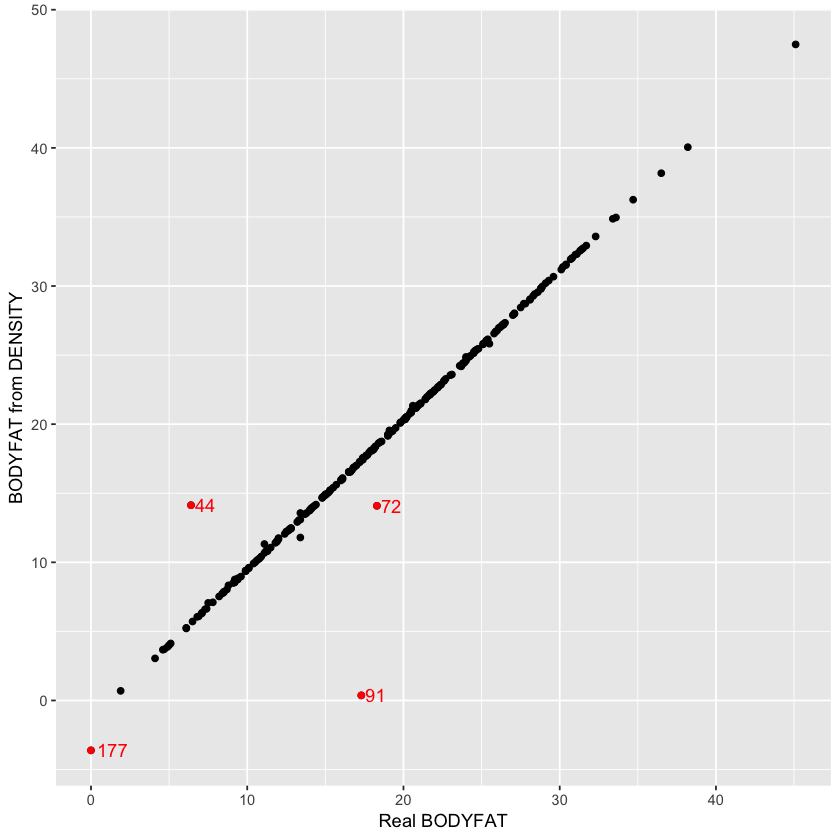

In [7]:
df = data.frame(Real = dat$BODYFAT, Fit = 495 / dat$DENSITY - 450)
is_outlier2 <- function(x) {#Function to detect outlier
  return(x < mean(x) - 2 * sd(x) | x > mean(x) + 2 * sd(x)) #Use normal assumption to detect outlier
}
df_tmp = df %>%
  mutate(dif = (Fit - Real)) %>%
  mutate(outlier = ifelse(is_outlier2(dif), 1,  as.numeric(NA)))

for(i in 1:nrow(df_tmp)){ #Change the outlier value to their index
  if(!is.na(df_tmp$outlier[i])) 
    df_tmp$outlier[i] = i %% nrow(df_tmp)
}
df$outlier = df_tmp$outlier
ggplot(data = df, aes(x = Real, y = Fit))+
  geom_point()+
  geom_point(data = df[!is.na(df$outlier),], color = 'red')+
  geom_text(aes(label = outlier), na.rm = TRUE, hjust = -0.2, color = 'red')+
  labs(x = 'Real BODYFAT', y = 'BODYFAT from DENSITY')

According to this scatterplot, the observations 44, 72, 91 and 177 have different real BODYFAT and calculated BODYFAT. It is hard to detect whether the BODYFAT or DENSITY is wrong, so we decide to delete these four observations instead of change the data. 

After we test the BODYFAT variable, we consider the BMI variable. The BMI is calculated by height and weight data. We find the real BMI is sometimes different with the calculated BMI.

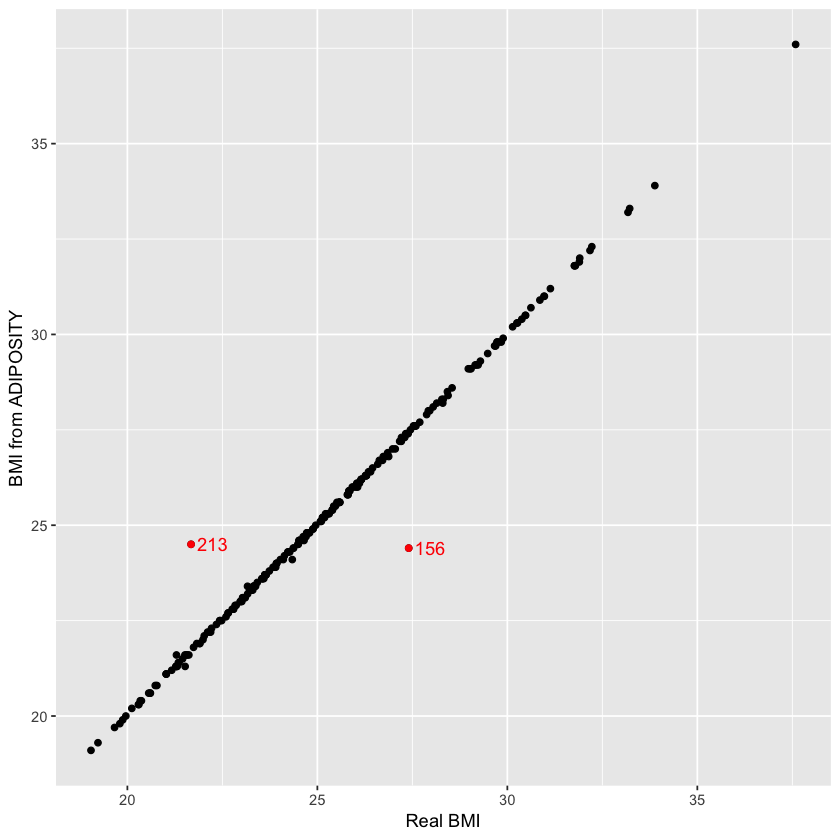

In [8]:
dat <- dat[-c(44, 72,177),]
df = data.frame(Real = 703 * dat$WEIGHT / dat$HEIGHT ^ 2, Fit = dat$ADIPOSITY)

df_tmp = df %>%
  mutate(dif = (Fit - Real)) %>%
  mutate(outlier = ifelse(is_outlier2(dif), 1,  as.numeric(NA)))

for(i in 1:nrow(df_tmp)){ #Change the outlier value to their index
  if(!is.na(df_tmp$outlier[i])) 
    df_tmp$outlier[i] = i %% nrow(df_tmp)
}
df$outlier = df_tmp$outlier
ggplot(data = df, aes(x = Real, y = Fit))+
  geom_point()+
  geom_point(data = df[!is.na(df$outlier),], color = 'red')+
  geom_text(aes(label = outlier), na.rm = TRUE, hjust = -0.2, color = 'red')+
  labs(x = 'Real BMI', y = 'BMI from ADIPOSITY')

According to this plot, observation 210 and 154 have different real BMI and calculated BMI. As the same reason, we decide to delete these two observations.

In [9]:
dat <- dat[-c(156, 213),-2]

Our data cleaning is done. The next step is model selection.

## 3. Statistical Modeling and Analysis

We decide to use linear regression model, because it is simple and accurate enough. 

Firstly, we try to use stepwise variable selection. We take the AIC as the criteria of the selection process. We start the variable selection from full model, and use both side stepwise selection. 

In [10]:
step(lm(BODYFAT ~ ., data = dat), direction = "both", k = 2, trace = 0)


Call:
lm(formula = BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + ABDOMEN + 
    THIGH + FOREARM + WRIST, data = dat)

Coefficients:
(Intercept)          AGE       WEIGHT       HEIGHT    ADIPOSITY      ABDOMEN  
 -105.99617      0.04637     -0.31452      1.01849      1.53385      0.80755  
      THIGH      FOREARM        WRIST  
    0.19662      0.28823     -1.43127  


According to the result of R code, the model selected by stepwise AIC is BODYFAT ~ AGE + ADIPOSITY + NECK + CHEST + ABDOMEN + HIP + FOREARM + WRIST. This model is not simple at all. It has 7 predictors, which is very unfriendly to customers. And the predictors selected by AIC criteria still have terrible collinearity problem. We calculate the VIF of these predictors.

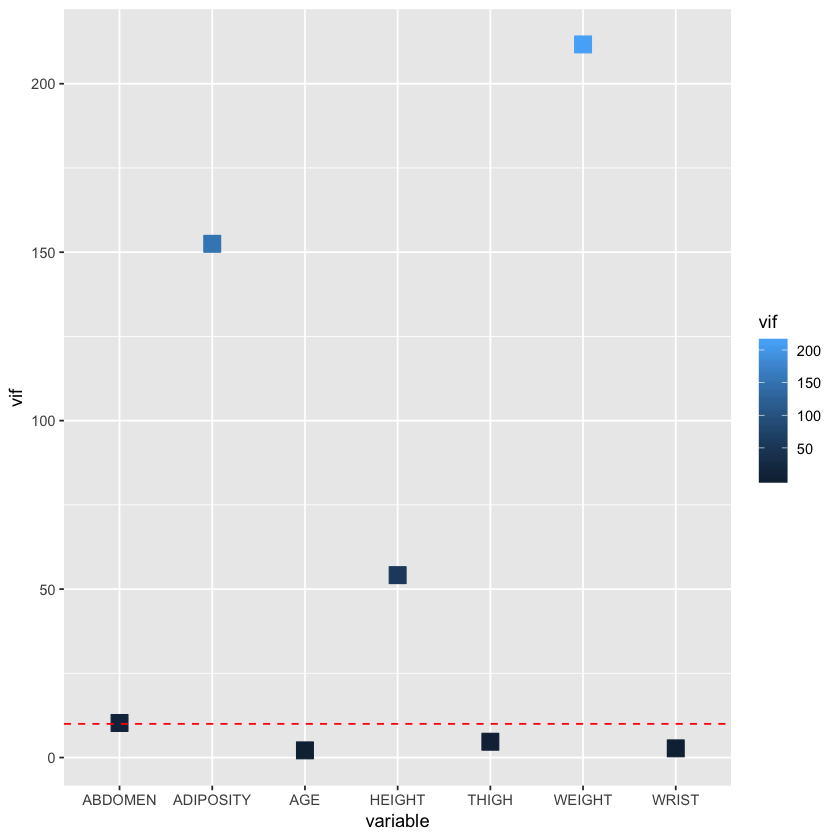

In [11]:
df <- data.frame(v = vif(lm(BODYFAT ~ AGE + HEIGHT + ADIPOSITY + THIGH + WEIGHT + ABDOMEN + WRIST, data = dat)))
df <- data.frame(variable = rownames(df), vif = vif(lm(BODYFAT ~ AGE + HEIGHT + ADIPOSITY + THIGH + WEIGHT + ABDOMEN + WRIST, data = dat)))
ggplot(data = df, aes(x = variable, y = vif))+
  geom_point(aes(color = vif, fill = vif),shape = 22, size = 5)+
  geom_hline(yintercept = 10, linetype = 'dashed', color = 'red')

From this plot, we can see that there are four predictors with VIF larger than 10, which indicate the collinearity problem.

To find a simple model with no collinearity problem, we decide to try simple linear regression models. We also recognize the product and ratio of two variables as a form of single predictor. We enumerate all models with single predictor, and use leave-one-out cross validation to find the model with the lowest MSE.

In [12]:
cv_single <- function(i){
  mse <- 0
  for(k in 1:242){
    train <- dat[-k,]
    test <- dat[k,]
    coef <- lm(BODYFAT ~ train[,i], train)$coef
    y_hat <- coef%*%c(1, test[,i])
    mse <- mse + (y_hat - test$BODYFAT)^2
  }
  return(mse/242)
}

cv_div <- function(i,j){
  mse <- 0
  for(k in 1:242){
    train <- dat[-k,]
    test <- dat[k,]
    aa <- train[,i]/train[,j]
    coef <- lm(BODYFAT ~ aa, train)$coef
    y_hat <- coef%*%c(1, test[,i]/test[,j])
    mse <- mse + (y_hat - test$BODYFAT)^2
  }
  return(mse/242)
}

cv_mul <- function(i,j){
  mse <- 0
  for(k in 1:242){
    train <- dat[-k,]
    test <- dat[k,]
    aa <- train[,i]*train[,j]
    coef <- lm(BODYFAT ~ aa, train)$coef
    y_hat <- coef%*%c(1, test[,i]*test[,j])
    mse <- mse + (y_hat - test$BODYFAT)^2
  }
  return(mse/242)
}

min_mul <- Inf
for(i in 2:15){
  for(j in 2:15){
    if(i==j)
      next
    temp <- cv_mul(i,j)
    if(temp< min_mul){
      var_mul1 <- names(dat)[i]
      var_mul2 <- names(dat)[j]
      min_mul <- temp
    }
  }
}

min_div <- Inf
for(i in 2:15){
  for(j in 2:15){
    if(i==j)
      next
    temp <- cv_div(i,j)
    if(temp< min_div){
      var_div1 <- names(dat)[i]
      var_div2 <- names(dat)[j]
      min_div <- temp
    }
  }
}

min_single <- Inf
for(i in 2:15){
  temp <- cv_single(i)
  if(temp< min_single){
    var_single <- names(dat)[i]
    min_single <- temp
  }
}

mse <- matrix(c(min_single, min_mul, min_div))
rownames(mse) <- c(var_single, paste(var_mul1,"*",var_mul2, sep = ""), paste(var_div1,"/",var_div2, sep = ""))
colnames(mse) <- "MSE of CV"

In [13]:
print(mse)

                  MSE of CV
ABDOMEN            18.62660
ADIPOSITY*ABDOMEN  21.52252
ABDOMEN/HEIGHT     17.05912


According to the result of the enumeration, the simple linear regression model with the lowest MSE is BODYFAT ~ ABDOMEN / HEIGHT, which means we believe this is the best model with one predictor.

In [14]:
ratio <- dat$ABDOMEN/dat$HEIGHT
r.squared <- matrix(c(summary(lm(dat$BODYFAT ~ ratio))$r.squared, summary(lm(BODYFAT ~ AGE + HEIGHT + ABDOMEN + WRIST, data = dat))$r.squared))
colnames(r.squared) <- "R^2"
rownames(r.squared) <- c("BODYFAT ~ ABDOMEN/HEIGHT..............................", "BODYFAT ~ AGE + HEIGHT + ABDOMEN + WRIST....")
print(r.squared)

                                                             R^2
BODYFAT ~ ABDOMEN/HEIGHT.............................. 0.7056768
BODYFAT ~ AGE + HEIGHT + ABDOMEN + WRIST....           0.7348087


Finally we compare these two models, and we find that the R square of the simple model is almost the same with the complicated one. So our final model is the simple one, BODYFAT ~ ABDOMEN / HEIGHT.

In [15]:
lm(dat$BODYFAT ~ ratio)


Call:
lm(formula = dat$BODYFAT ~ ratio)

Coefficients:
(Intercept)        ratio  
     -39.82        44.72  


According to the result of the regression model estimation, our final model is: 
 


                                        ( Body fat %) = 44.72 * Abdomen circumference(cm) / Height(inches) - 39.82

## 4. Diagnostics

After we determine the model, we conduct the model diagnostics.

Firstly, we draw the scatterplot of the predictor and dependent variable. From the plot, we can see that the predictor and the dependent variable has strong linear relationship, so we believe the assumption of linearity is satisfied for this model.

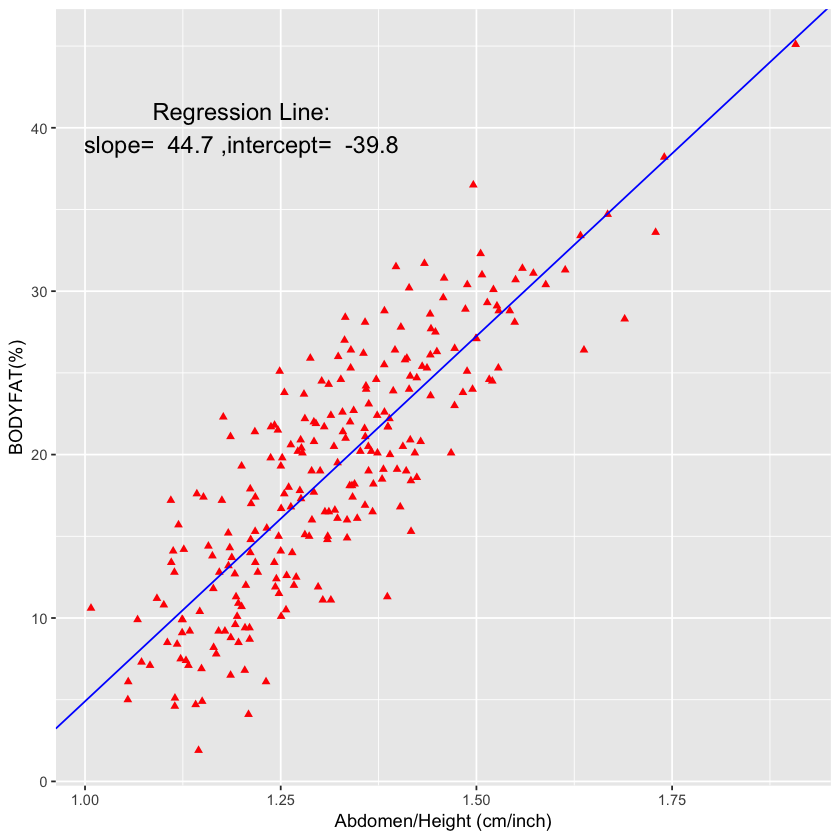

In [17]:
d=dat
d$AH=d$ABDOMEN/d$HEIGHT
modelx=lm(d$BODYFAT~d$AH)
d$predict=predict(modelx)
d$resid=resid(modelx)
d$stanresid=rstandard(modelx)
d$n=c(1:242)
d$cook=cooks.distance(modelx)
d$cookspecial=c(rep(0,227),1,rep(0,11),1,rep(0,2))
ggplot(d, aes(AH, BODYFAT))+
  geom_point(shape=17,color="red")+
  labs(x = "Abdomen/Height (cm/inch)", y = "BODYFAT(%)")+
  geom_abline(intercept = -39.8,slope =44.7,color="blue")+
  annotate("text",x=1.2,y=c(41,39),label=c("Regression Line:","slope=  44.7 ,intercept=  -39.8"),size=5)

Then, we draw the Q-Q plot of the residuals, from this qqnorm plot, we find nothing unusual, which means the assumption of normality should be satisfied. Also, we do a shapiro test, and find that the p-value of the test is 0.46, greater than 0.05, so the null hypothesis cannot be rejected, which also confirm that the assumption of normality is satisfied.

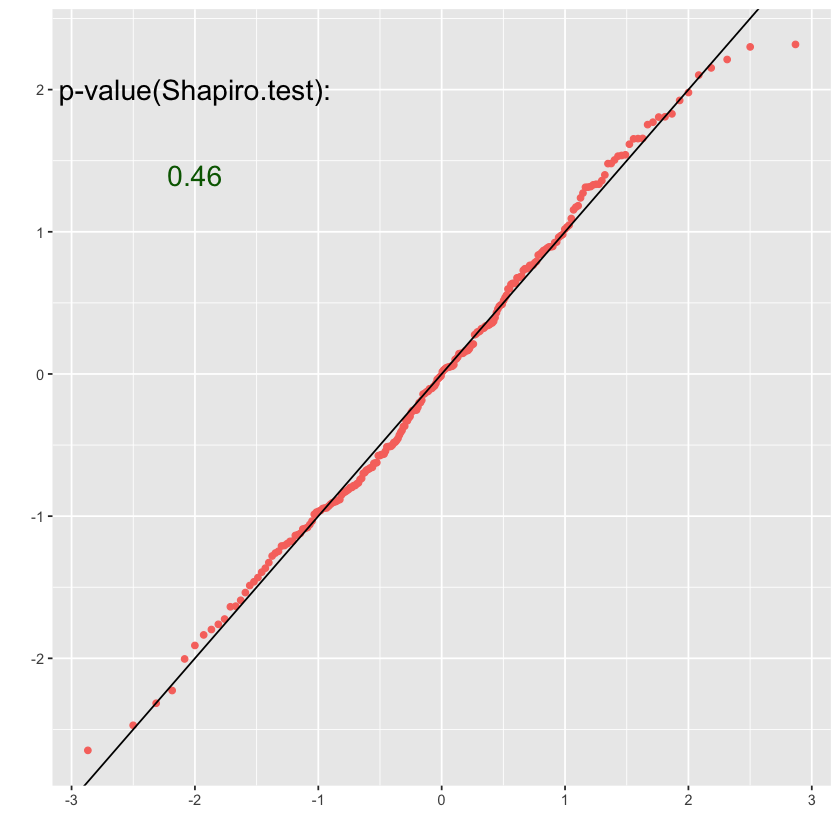

In [18]:
qplot(sample=stanresid, data=d,color="red")+
  geom_abline(intercept = 0,slope =1)+
  theme(legend.position='none')+
  annotate("text",x=c(-2,-2),y=c(2,1.4),label=c("p-value(Shapiro.test):","0.46"),color=c("black","darkgreen"),size=6)


Next, we draw the residuals vs fitted values plot. From this plot, we cannot see pattern of trumpet, which indicate that the assumption of homoscedasticity is not violated.

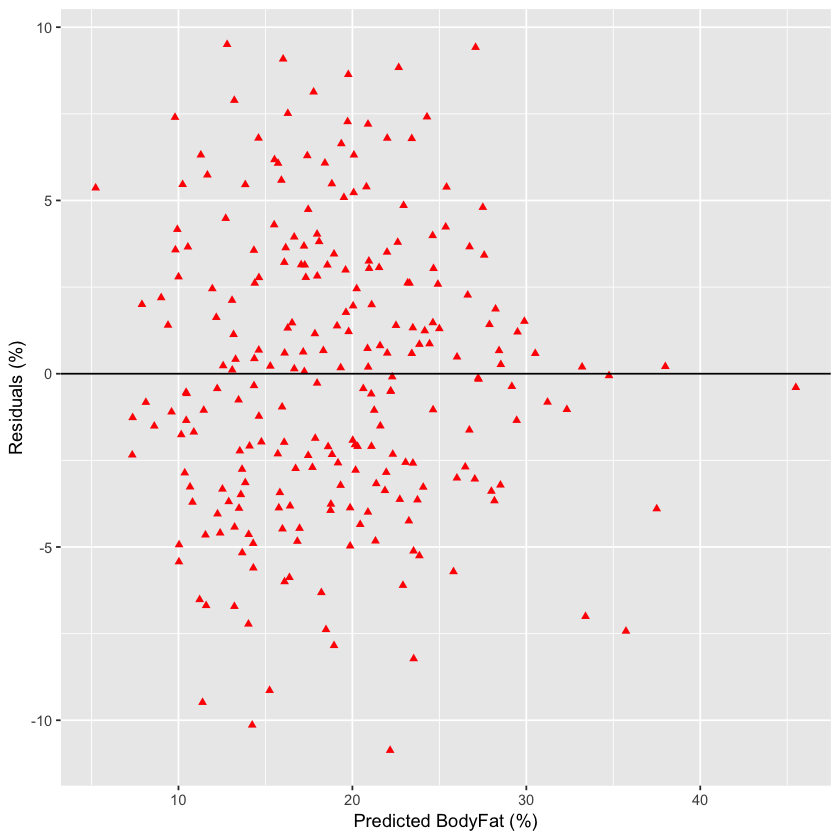

In [20]:
ggplot(d,aes(predict,resid))+ 
  geom_point(shape=17,color="red")+
  labs(x = "Predicted BodyFat (%)", y = "Residuals (%)")+
  geom_abline(intercept = 0,slope =0,color="black")

Finally, we analysis the Cook's distances. According to this Cook's Distances plot, we cannot find any points with very high influence.

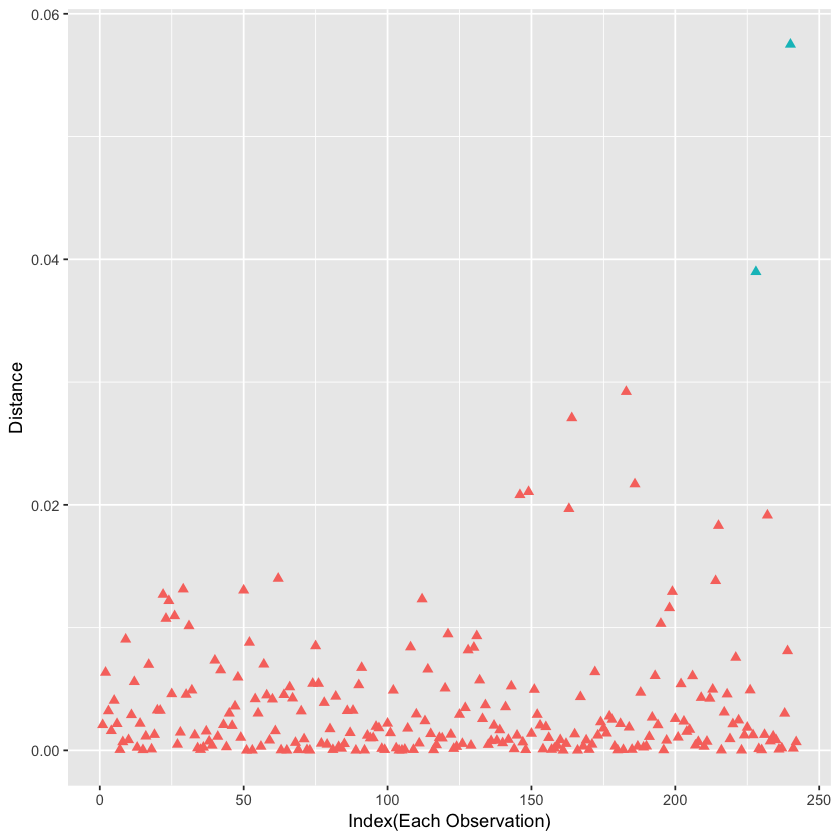

In [22]:
ggplot(d,aes(n,cook,color=factor(cookspecial)))+
  geom_point(shape=17,size=2)+
  theme(legend.position='none')+
  labs(x = "Index(Each Observation)", y = "Distance")

According to the result of the regression model estimation, our final model is: 
 


                                        ( Body fat %) = 44.72 * Abdomen circumference(cm) / Height(inches) - 39.82

Rule of thumb of the model: Divide your abdomen circumference(cm) by your height(inches), then multiple 45 and then minus 40

Strengths of the Model:

1. The assumptions of normality, linearity and homoscedasticity are satisfied wel.

2. This model is very simple and easy to understand.

3. This model is relatively robust compared with traditional additive models.

Weekness of the Model:

4. This model is not very accurate since its number of predictors is small.

Contribution: 

Siyu Wang: First 1/3 PPT (data cleaning part); Data cleaning code; Arranging Github Repository

Tianqi Li: Second 1/3 PPT (model selection part); Stepwise and enumeration selection code; Writing Jupyter notebook

Tiannan Huang: Third 1/3 PPT (diagnostic part); Diagnostic code; Constructing shiny app